In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import pymedphys

In [16]:
reference_filepath = "C:/Users/I0327140/Outliers_Study/DVH_Dose_Effect/BS_Ref.dcm"
evaluation_filepath = "C:/Users/I0327140/Outliers_Study/DVH_Dose_Effect/BS_Outer.dcm"

In [17]:
reference = pydicom.read_file(reference_filepath)
evaluation = pydicom.read_file(evaluation_filepath)

In [18]:
axes_reference, dose_reference = pymedphys.dicom.zyx_and_dose_from_dataset(reference)
axes_evaluation, dose_evaluation = pymedphys.dicom.zyx_and_dose_from_dataset(evaluation)

(z_ref, y_ref, x_ref) = axes_reference
(z_eval, y_eval, x_eval) = axes_evaluation

In [20]:
gamma_options = {
    'dose_percent_threshold': 3,
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 20,
    'interp_fraction': 10,  # Should be 10 or more for more accurate results
    'max_gamma': 2,
    'random_subset': None,
    'local_gamma': True,
    'ram_available': 2**29  # 1/2 GB
}

gamma = pymedphys.gamma(
    axes_reference, dose_reference, 
    axes_evaluation, dose_evaluation, 
    **gamma_options)

Calcing using local normalisation point for gamma
Global normalisation set to 63.995205524888206
Global dose threshold set to [1.91985617] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 12.799041104977642 (20% of normalisation)

Current distance: 6.00 mm | Number of reference points remaining: 30109 | Points tested per reference point: 1 | RAM split count: 1 | Points tested per reference point: 23 | RAM split count: 1 | Points tested per reference point: 67 | RAM split count: 2 | Points tested per reference point: 135 | RAM split count: 3 | Points tested per reference point: 227 | RAM split count: 4 | Points tested per reference point: 348 | RAM split count: 5 | Points tested per reference point: 485 | RAM split count: 5 | Points tested per reference point: 652 | RAM split count: 6 | Points tested per reference point: 871 | RAM split count: 7 | Points tested per reference point: 1089 | RAM split count: 7 | Points tested per reference point: 1331 | RAM sp

Text(0.5, 1.0, 'Local Gamma (3%/3mm) | Percent Pass: 84.53 %')

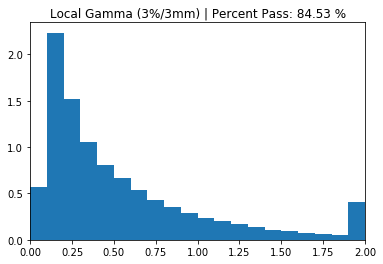

In [21]:
valid_gamma = gamma[~np.isnan(gamma)]

num_bins = (
    gamma_options['interp_fraction'] * gamma_options['max_gamma'])
bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

plt.hist(valid_gamma, bins, density=True)
plt.xlim([0, gamma_options['max_gamma']])

pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)

plt.title(f"Local Gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Percent Pass: {pass_ratio*100:.2f} %")
# plt.savefig('gamma_hist.png', dpi=300)

In [22]:
max_ref_dose = np.max(dose_reference)

lower_dose_cutoff = gamma_options['lower_percent_dose_cutoff'] / 100 * max_ref_dose

relevant_slice = (
    np.max(dose_reference, axis=(1, 2)) > 
    lower_dose_cutoff)
slice_start = np.max([
        np.where(relevant_slice)[0][0], 
        0])
slice_end = np.min([
        np.where(relevant_slice)[0][-1], 
        len(z_ref)])

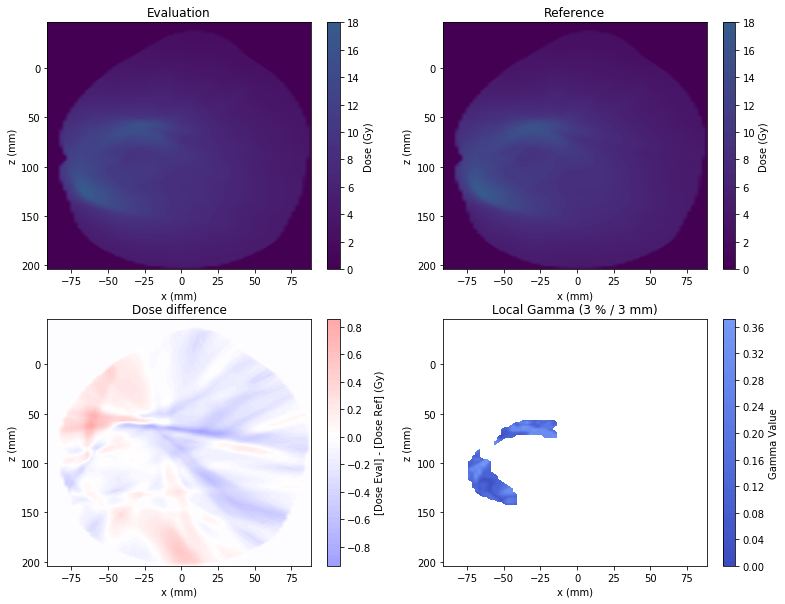

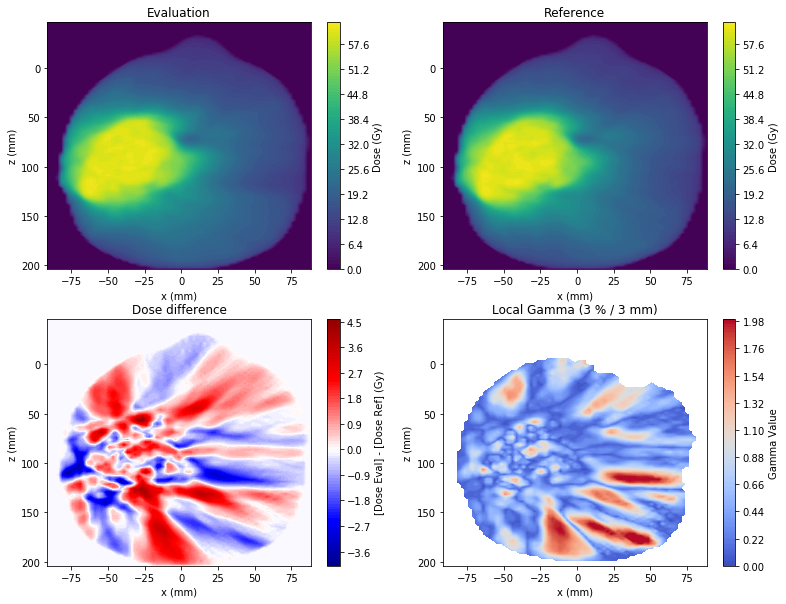

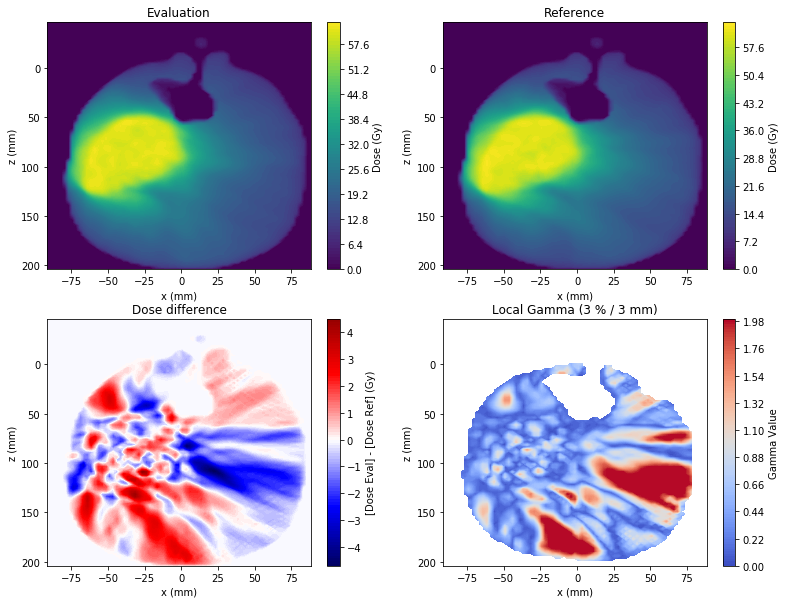

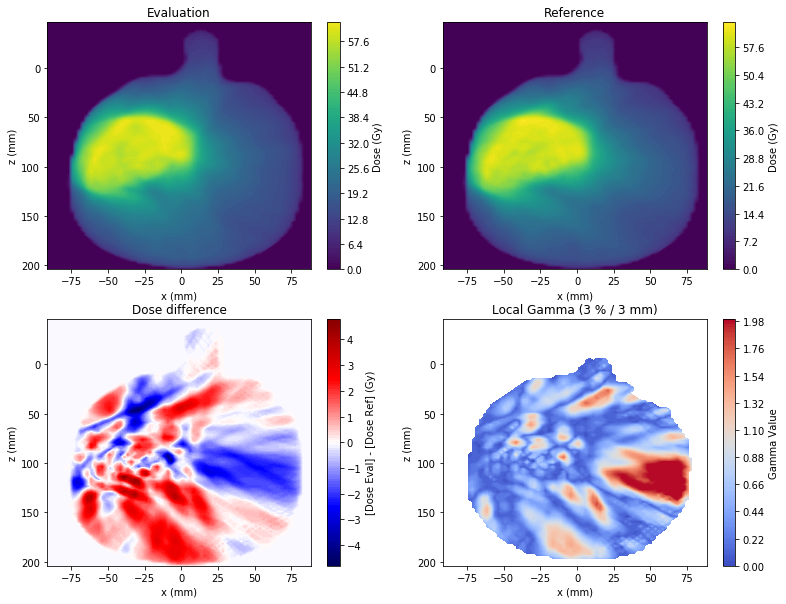

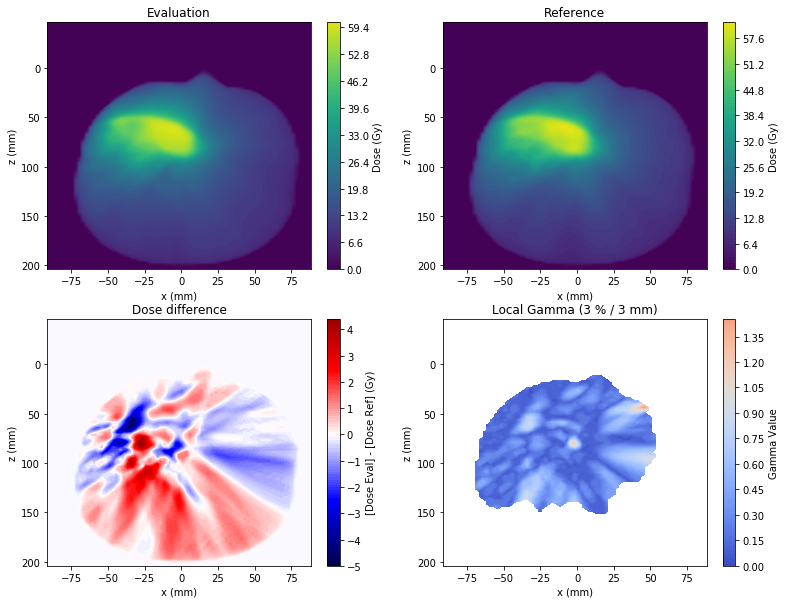

In [23]:
z_vals = z_ref[slice(slice_start, slice_end, 5)]

eval_slices = [
    dose_evaluation[np.where(z_i == z_eval)[0][0], :, :]
    for z_i in z_vals
]

ref_slices = [
    dose_reference[np.where(z_i == z_ref)[0][0], :, :]
    for z_i in z_vals
]

gamma_slices = [
    gamma[np.where(z_i == z_ref)[0][0], :, :]
    for z_i in z_vals
]

diffs = [
    eval_slice - ref_slice
    for eval_slice, ref_slice 
    in zip(eval_slices, ref_slices)
]

max_diff = np.max(np.abs(diffs))



for i, (eval_slice, ref_slice, diff, gamma_slice) in enumerate(zip(eval_slices, ref_slices, diffs, gamma_slices)):    
    fig, ax = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
   
    c00 = ax[0,0].contourf(
        x_eval, y_eval, eval_slice, 100, 
        vmin=0, vmax=max_ref_dose)
    ax[0,0].set_title("Evaluation")
    fig.colorbar(c00, ax=ax[0,0], label='Dose (Gy)')
    ax[0,0].invert_yaxis()
    ax[0,0].set_xlabel('x (mm)')
    ax[0,0].set_ylabel('z (mm)')
    
    c01 = ax[0,1].contourf(
        x_ref, y_ref, ref_slice, 100, 
        vmin=0, vmax=max_ref_dose)
    ax[0,1].set_title("Reference")  
    fig.colorbar(c01, ax=ax[0,1], label='Dose (Gy)')
    ax[0,1].invert_yaxis()
    ax[0,1].set_xlabel('x (mm)')
    ax[0,1].set_ylabel('z (mm)')

    c10 = ax[1,0].contourf(
        x_ref, y_ref, diff, 100, 
        vmin=-max_diff, vmax=max_diff, cmap=plt.get_cmap('seismic'))
    ax[1,0].set_title("Dose difference")    
    fig.colorbar(c10, ax=ax[1,0], label='[Dose Eval] - [Dose Ref] (Gy)')
    ax[1,0].invert_yaxis()
    ax[1,0].set_xlabel('x (mm)')
    ax[1,0].set_ylabel('z (mm)')
    
    c11 = ax[1,1].contourf(
        x_ref, y_ref, gamma_slice, 100, 
        vmin=0, vmax=2, cmap=plt.get_cmap('coolwarm'))
    ax[1,1].set_title(
        f"Local Gamma ({gamma_options['dose_percent_threshold']} % / {gamma_options['distance_mm_threshold']} mm)")    
    fig.colorbar(c11, ax=ax[1,1], label='Gamma Value')
    ax[1,1].invert_yaxis()
    ax[1,1].set_xlabel('x (mm)')
    ax[1,1].set_ylabel('z (mm)')
    
    plt.show()
    print("\n")    